### General information

This kernel is intented to help mlcourse.ai participants with doing EDA, Feature Engineering and building models.

* At first I'll do basic EDA of the data;
* After this I'll build a baseline model to see how good model can be on the basic data;
* Then I'll create new features based on the main features and train a model again to see whether there is an improvement;
* After this I'll try to extract new features from json files and see whether it helps;

In [1]:
# -*- coding: future_fstrings -*-

In [2]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from tqdm import tqdm_notebook
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

# import json
import altair as alt
from  altair.vega import v3
from IPython.display import HTML

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [3]:
import ujson as json

In [4]:
def get_timestamp_without_msecs():
    """
    Example: '2017-03-07T15:41:41.458000' -> '20170307T154141'
    :return:
    """
    timestamp = datetime.datetime.now().isoformat().replace('-', '').replace(':', '')
    if re.match('^\d{8}T\d{6}$', timestamp):
        # Zero microseconds case
        timestamp += '.000000'        
    assert re.match('^\d{8}T\d{6}\.\d{6}$', timestamp), "Unexpected format of datetime: {}".format(timestamp)
    return timestamp[:-7]


def gen_subm_name(suffix):
    return 'subm_a4_{}_{}.csv'.format(get_timestamp_without_msecs(), suffix)

In [5]:
# Preparing altair. I use code from this great kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey

vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
)))

## Data overview

In [6]:
%%time
DATA_FOLDER=r'D:/BigData2/2019-04_Kaggle_Dota/'
train = pd.read_csv(DATA_FOLDER + 'input/train_features.csv', index_col='match_id_hash')
target = pd.read_csv(DATA_FOLDER + 'input/train_targets.csv', index_col='match_id_hash')
test = pd.read_csv(DATA_FOLDER + 'input/test_features.csv', index_col='match_id_hash')

Wall time: 1.87 s


In [7]:
train = train.head(100)
target = target.head(100)
test = test.head(100)

In [8]:
target.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


In [9]:
target['radiant_win'].value_counts()

False    53
True     47
Name: radiant_win, dtype: int64

There is some disbalance in data, but it isn't too high, so we don't need to do anything special to tackle it.

In [10]:
train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.000000,0,0,1,0,0.000000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,2,124,126,0.000000,0,0,0,0,0.000000,0,0,0,0,14,0,1,0,0,304,0,130,700,700,242.93773,1,70,156,0.000000,0,0,1,0,0.000000,0,0,0,0,59,0,0,0,1,389,4,506,399,700,326.93780,2,170,86,0.000000,0,0,0,0,0.000000,0,0,0,0,77,0,0,0,0,402,10,344,422,800,314.93780,2,120,100,0.000000,0,0,0,0,0.000000,0,0,0,0,12,0,0,1,13,982,12,780,650,720,386.93787,3,82,170,0.000000,0,0,1,0,1.00,0,0,0,0,21,0,0,0,6,788,9,706,640,640,422.93790,3,174,90,0.000000,0,0,2,0,0.00,0,0,0,0,60,0,0,0,1,531,0,307,720,720,242.93773,2,180,84,0.299948,0,0,2,0,0.00,0,0,0,0,84,1,0,0

In [11]:
import future_fstrings

In [12]:
# -*- coding: future_fstrings -*-
#print(f'Number of samples in train: {train.shape[0]}')
#print(f'Number of columns in train: {train.shape[1]}')
for col in train.columns:
    if train[col].isnull().any():
        print(col, train[col].isnull().sum())

## A short notice on data visualization

Currently there are a lot of great libraries for data visualization in Python and I usually use several of them:
- basic pandas plotting: this is a simplified version of using matplotlib, which can be used for some fast and simple plotting;
- matplotlib: you can do everything, though it can require a lot of code. Also making interactive plots is difficult or impossible;
- seaborn: it is good when you want to plot interactions between several features;
- plotly: I used it to make interactive plots and it is great for this, but recently I switched to altair;
- altair: this is a python wrapper for vega-lite. It is possible to make almost any plot there and interactivity is great. On the other hand it could be difficult to get used to it's syntax;

Let's see how to plot a barchart in different libraries. We'll plot a countplot for game_mode in train data.

In [13]:
train['game_mode'].value_counts()

22    82
4     10
23     5
3      3
Name: game_mode, dtype: int64

### Pandas plotting

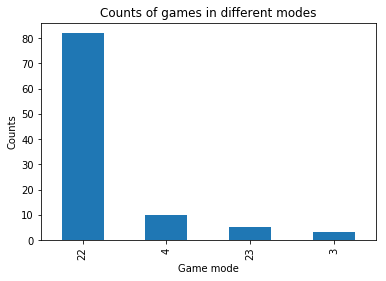

In [14]:
ax = train['game_mode'].value_counts().plot(kind='bar', title='Counts of games in different modes');
ax.set_xlabel("Game mode");
ax.set_ylabel("Counts");

### Matplotlib

In [15]:
train_modes = train['game_mode'].value_counts().reset_index().rename(columns={'index': 'game_mode', 'game_mode': 'count'})
train_modes

,game_mode,count
0,22,82
1,4,10
2,23,5
3,3,3


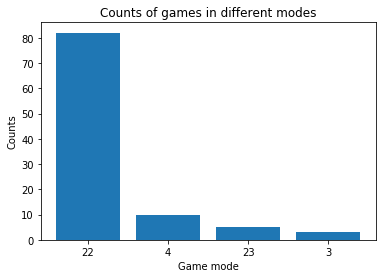

In [16]:
plt.bar(range(len(train_modes['game_mode'])), train_modes['count']);
plt.xticks(range(len(train_modes['game_mode'])), train_modes['game_mode']);
plt.xlabel('Game mode');
plt.ylabel('Counts');
plt.title('Counts of games in different modes');

### Seaborn

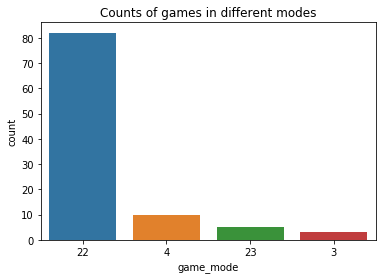

In [17]:
sns.countplot(data=train, x='game_mode', order=train['game_mode'].value_counts().index);
plt.title('Counts of games in different modes');

### Plotly

In [18]:
train_modes['game_mode'] = train_modes['game_mode'].astype(str)
data=[go.Bar(
    x=train_modes['game_mode'],
    y=train_modes['count'],
    name='Game mode'
)]

layout = go.Layout(title='Counts of games in different modes',
                  xaxis=dict(title='Game mode'),
                  yaxis=dict(title='Count'))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='bar')

### Altair
For altair to show in kaggle kernels, it is necessary to wrap in in a special function.

In [19]:
render(alt.Chart(train_modes).mark_bar().encode(
    x=alt.X("game_mode:N", axis=alt.Axis(title='Game modes'), sort=list(train_modes['game_mode'].values)),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['game_mode', 'count']
).properties(title="Counts of games in different modes", width=400).interactive())

## Data exploration

### game_time

In [20]:
train['radiant_win'] = target['radiant_win']

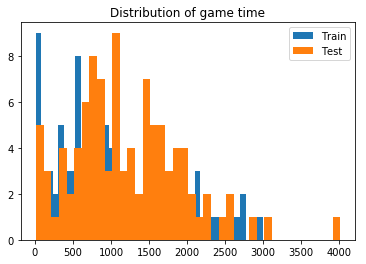

In [21]:
plt.hist(train['game_time'], bins=40, label='Train');
plt.hist(test['game_time'], bins=40, label='Test');
plt.title('Distribution of game time');
plt.legend();

We can see that the distribution of game time in train and test data is quite similar.

### game_mode

In [22]:
train_games = alt.Chart(train_modes).mark_bar().encode(
    x=alt.X("game_mode:N", axis=alt.Axis(title='Game modes'), sort=list(train_modes['game_mode'].values)),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['game_mode', 'count']
).properties(title="Counts of games in different modes in train data", width=400).interactive()

test_modes = test['game_mode'].value_counts().reset_index().rename(columns={'index': 'game_mode', 'game_mode': 'count'})
test_games = alt.Chart(test_modes).mark_bar().encode(
    x=alt.X("game_mode:N", axis=alt.Axis(title='Game modes'), sort=list(train_modes['game_mode'].values)),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['game_mode', 'count']
).properties(title="Counts of games in different modes in test data", width=400).interactive()

d = train.groupby(['game_mode', 'radiant_win'])['game_time'].count().reset_index().rename(columns={'game_time': 'count'})
train_r = alt.Chart(d).mark_bar().encode(
    x=alt.X("radiant_win:N", axis=alt.Axis(title='Radiant win'), sort=list(train_modes['game_mode'].values)),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    column='game_mode',
    color='radiant_win:N',
    tooltip=['game_mode', 'radiant_win', 'count']
).properties(title="Counts of wins and losses by game mode", width=100).interactive()

render(train_games | test_games)

In [23]:
render(train_r)

First thing worth noticing - there are 8 game modes in train data and only 7 games in test data. But the game mode `16` in train data has only 2 samples, so we can combine it with other game types. Otherwise the distribution of game modes seems similar.

Wins and losses are more or less equally distributed over game modes.

### Player features

Here we have features for separate players. Let's have a look at the distribution of one of them.

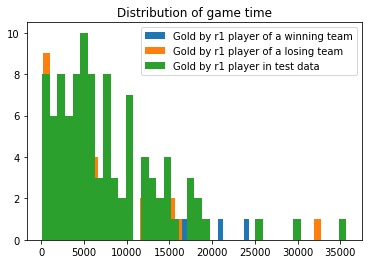

In [24]:
plt.hist(train.loc[train['radiant_win'] == True, 'r1_gold'], bins=40, label='Gold by r1 player of a winning team');
plt.hist(train.loc[train['radiant_win'] == False, 'r1_gold'], bins=40, label='Gold by r1 player of a losing team');
plt.hist(test['r1_gold'], bins=40, label='Gold by r1 player in test data');
plt.title('Distribution of game time');
plt.legend();

Nothing interesting... as it should be expected!
This feature shows gold earned by a first player. Of course distributions of this feature in train and test should be similar, as first player is chosen randomly.

Let's build a first model on the existing features and look at its quality.

### First model

In [25]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

Training function

In [26]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

Fold 0 started at Sat Apr 20 11:11:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Fold 1 started at Sat Apr 20 11:11:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Fold 2 started at Sat Apr 20 11:11:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Fold 3 started at Sat Apr 20 11:11:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Fold 4 started at Sat Apr 20 11:11:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
CV mean score: 0.5000, std: 0.0000.


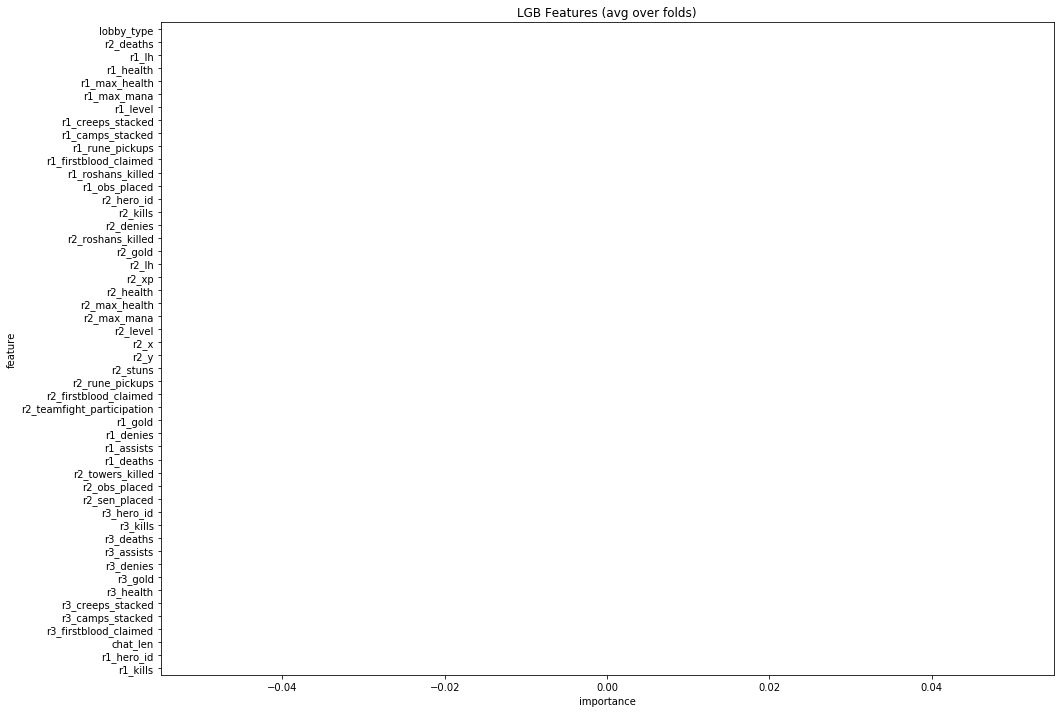

In [27]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = train['radiant_win']
X_test = test.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

So this was our baseline model.
We can see that features in top-50 show variuos aspects of player activity, but gold and health are prevalent. Let's get started with feature engineering.

### Feature engineering on basic data

My idea behind this FE is the following:
Let's take gold, for example. Gold earned by each player can't give us a lot of information. But what is we take total gold by the team? Maybe teams with more gold earned usually win. What if we take mean and std of players' gold in a team? Maybe teams where players tend to have similar parameters are more likely to win. Let's try creating these features.

In [ ]:
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']:
    #r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    #d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    r_columns = ['r{}_{}'.format(i, c) for i in range(1, 6)]
    d_columns = ['d{}_{}'.format(i, c) for i in range(1, 6)]
    
    train['r_total_' + c] = train[r_columns].sum(1)
    train['d_total_' + c] = train[d_columns].sum(1)
    train['total_' + c + '_ratio'] = train['r_total_' + c] / train['d_total_' + c]
    
    test['r_total_' + c] = test[r_columns].sum(1)
    test['d_total_' + c] = test[d_columns].sum(1)
    test['total_' + c + '_ratio'] = test['r_total_' + c] / test['d_total_' + c]
    
    train['r_std_' + c] = train[r_columns].std(1)
    train['d_std_' + c] = train[d_columns].std(1)
    train['std_' + c + '_ratio'] = train['r_std_' + c] / train['d_std_' + c]

In [ ]:
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']:
    #r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    #d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    r_columns = ['r{}_{}'.format(i, c) for i in range(1, 6)]
    d_columns = ['d{}_{}'.format(i, c) for i in range(1, 6)]
    
    train['r_total_' + c] = train[r_columns].sum(1)
    train['d_total_' + c] = train[d_columns].sum(1)
    train['total_' + c + '_ratio'] = train['r_total_' + c] / train['d_total_' + c]
    
    test['r_total_' + c] = test[r_columns].sum(1)
    test['d_total_' + c] = test[d_columns].sum(1)
    test['total_' + c + '_ratio'] = test['r_total_' + c] / test['d_total_' + c]
    
    train['r_std_' + c] = train[r_columns].std(1)
    train['d_std_' + c] = train[d_columns].std(1)
    train['std_' + c + '_ratio'] = train['r_std_' + c] / train['d_std_' + c]
    
    test['r_std_' + c] = test[r_columns].std(1)
    test['d_std_' + c] = test[d_columns].std(1)
    test['std_' + c + '_ratio'] = test['r_std_' + c] / test['d_std_' + c]
    
    train['r_mean_' + c] = train[r_columns].mean(1)
    train['d_mean_' + c] = train[d_columns].mean(1)
    train['mean_' + c + '_ratio'] = train['r_mean_' + c] / train['d_mean_' + c]
    
    test['r_mean_' + c] = test[r_columns].mean(1)
    test['d_mean_' + c] = test[d_columns].mean(1)
    test['mean_' + c + '_ratio'] = test['r_mean_' + c] / test['d_mean_' + c]

In [ ]:
X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = train['radiant_win']
X_test = test.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

As we can see, the score increased substantially thanks to the new features. Surprisingly hero id is still one of the top features.

But we used only the features from the basic features. Let's try working with json data to get more cool data!

### Working with json data

I'll use functions from this kernel: https://www.kaggle.com/kashnitsky/dota-2-win-prediction-random-forest-starter

In [ ]:
with open(os.path.join('input/', 'train_matches.jsonl')) as fin:
    # read the 18-th line
    for i in range(18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

In [ ]:
match.keys()

### players

@yorko has already extracted a lot of features from players data, but let's try to add more.
Here is the list of additional features:
- max ability level,
- max_hero_hit,
- amount of purchases,
- count of abilities used,
- total damage dealt,
- total damage received,

In [ ]:
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

In [ ]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
#         row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
#         row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
#         row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
#         row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
#         row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
#         row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))
        row.append(('{}_ability_level'.format(player_name), len(player['ability_upgrades'])))
        row.append(('{}_max_hero_hit'.format(player_name), player['max_hero_hit']['value']))
        row.append(('{}_purchase_count'.format(player_name), len(player['purchase_log'])))
        row.append(('{}_count_ability_use'.format(player_name), sum(player['ability_uses'].values())))
        row.append(('{}_damage_dealt'.format(player_name), sum(player['damage'].values())))
        row.append(('{}_damage_received'.format(player_name), sum(player['damage_taken'].values())))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

In [ ]:
# %%time
PATH_TO_DATA = 'input/'
df_new_features = []
df_new_targets = []

# counter = 0
for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    df_new_features.append(features)
    df_new_targets.append(targets)
#     counter += 1
#     if counter == 100:
#         break

In [ ]:
df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
df_new_targets = pd.DataFrame.from_records(df_new_targets).set_index('match_id_hash')

In [ ]:
test_new_features = []
# counter = 0
for match in read_matches(os.path.join(PATH_TO_DATA, 'test_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    
    test_new_features.append(features)
#     counter += 1
#     if counter == 100:
#         break
test_new_features = pd.DataFrame.from_records(test_new_features).set_index('match_id_hash')

In [ ]:
df_new_features.shape

In [ ]:
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed', 'ability_level', 'max_hero_hit', 'purchase_count',
          'count_ability_use', 'damage_dealt', 'damage_received']:
#     r_columns = [f'r{i}_{c}' for i in range(1, 6)]
#     d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    r_columns = ['r{}_{}'.format(i, c) for i in range(1, 6)]
    d_columns = ['d{}_{}'.format(i, c) for i in range(1, 6)]
    
    df_new_features['r_total_' + c] = df_new_features[r_columns].sum(1)
    df_new_features['d_total_' + c] = df_new_features[d_columns].sum(1)
    df_new_features['total_' + c + '_ratio'] = df_new_features['r_total_' + c] / df_new_features['d_total_' + c]
    
    test_new_features['r_total_' + c] = test_new_features[r_columns].sum(1)
    test_new_features['d_total_' + c] = test_new_features[d_columns].sum(1)
    test_new_features['total_' + c + '_ratio'] = test_new_features['r_total_' + c] / test_new_features['d_total_' + c]
    
    df_new_features['r_std_' + c] = df_new_features[r_columns].std(1)
    df_new_features['d_std_' + c] = df_new_features[d_columns].std(1)
    df_new_features['std_' + c + '_ratio'] = df_new_features['r_std_' + c] / df_new_features['d_std_' + c]
    
    test_new_features['r_std_' + c] = test_new_features[r_columns].std(1)
    test_new_features['d_std_' + c] = test_new_features[d_columns].std(1)
    test_new_features['std_' + c + '_ratio'] = test_new_features['r_std_' + c] / test_new_features['d_std_' + c]
    
    df_new_features['r_mean_' + c] = df_new_features[r_columns].mean(1)
    df_new_features['d_mean_' + c] = df_new_features[d_columns].mean(1)
    df_new_features['mean_' + c + '_ratio'] = df_new_features['r_mean_' + c] / df_new_features['d_mean_' + c]
    
    test_new_features['r_mean_' + c] = test_new_features[r_columns].mean(1)
    test_new_features['d_mean_' + c] = test_new_features[d_columns].mean(1)
    test_new_features['mean_' + c + '_ratio'] = test_new_features['r_mean_' + c] / test_new_features['d_mean_' + c]

Now let's try building a new model!

In [ ]:
# test_new_features.head()

In [ ]:
# df_new_features.head()

In [ ]:
# y.head()

In [ ]:
X = df_new_features.reset_index(drop=True)
X_test = test_new_features.copy().reset_index(drop=True)



oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)


In [ ]:
# X.head()

In [ ]:
# X_test.head()

In [ ]:
# y.head()

In [ ]:
train_df = pd.concat([X, y.reset_index(drop=True)], axis=1)
train_df.to_csv('train_20190419.csv', index=False)
X_test.to_csv('test_20190419.csv', index=False)

In [ ]:
import re
sub = pd.read_csv('input/sample_submission.csv')
sub['radiant_win_prob'] = prediction_lgb
filename = gen_subm_name('v02')
sub.to_csv(filename, index=False)
sub.head()

In [ ]:
plt.hist(prediction_lgb, bins=40);
plt.title('Distribution of predictions');